In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Sellers

🎯 Our goal is to find sellers who have repeatedly been underperforming vs. others, and understand why.  
This will help us shape our recommendations about how to improve Olist's profit margin for the future.

❗️ Long Notebook. Once you've read a section, you can collapse it.
<details>
    <summary> <i>[remainder] Notebook best practices</i></summary>

- Code your logic so that your Notebook can always be run from top to bottom without crashing (`Cell --> Run All`)
- Name your variables carefully 
- Use dummy names such as `tmp` for intermediary steps when you know you won't need them later
- Clear your code and merge cells when relevant to minimize Notebook size (`Shift-M`)
- Hide your cell output if you don't need to see it anymore (double click on the red `Out[]:` section to the left of your cell).
- Make heavy use of jupyter nbextention `Collapsable Headings` and `Table of Content` (call a TA if you can't find them)
- Use the following shortcuts 
    - `a` to insert a cell above
    - `b` to insert a cell below
    - `dd` to delete a cell
    - `esc` and `arrows` to move between cells
    - `Shift-Enter` to execute cell and move focus to the next one
    - use `Shift + Tab` when you're between method brackets e.g. `groupby()` to get the docs! Repeat a few times to open it permanently

</details>





## 1 - `olist/seller.py`  

In a process similar to `order.py`, we have coded for you the module `olist/seller.py` containing a class `Seller` with a method `Seller().get_training_data` that will return a DataFrame with the following features:
  
| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `seller_id` 	| str 	| the id of the seller **UNIQUE** 	|
| `seller_city` 	| str 	| the city where seller is located 	|
| `seller_state` 	| str 	| the state where seller is located 	|
| `delay_to_carrier` 	| float 	| returns 0 if the order is delivered before the shipping_limit_date, otherwise the value of the delay 	|
| `wait_time` 	| float 	| average wait_time (duration of deliveries) per seller 	|
| `date_first_sale` 	| datetime 	| date of the first sale on Olist 	|
| `date_last_sale` 	| datetime 	| date of the last sale on Olist 	|
| `months_on_olist` 	| float 	| round number of months  on Olist	|
| `share_of_five_stars` 	| float 	| share of five-star reviews for orders in which the seller was involved 	|
| `share_of_one_stars` 	| float 	| share of one-star reviews for orders in which the seller was involved 	|
| `review_score` 	| float 	| average review score for orders in which the seller was involved 	|
| `n_orders` 	| int 	| number of unique orders the seller was involved with 	|
| `quantity` 	| int 	| total number of items sold by this seller 	|
| `quantity_per_order` 	| float 	| average number of items per order for this seller 	|
| `sales` 	| float 	| total sales associated with this seller (excluding freight value) in BRL 	|  

❓ **Import your new class below and check out your training dataframe !** Take time to look at the code and understand exactly what has been computed for you

In [3]:
from olist.seller import Seller


seller = Seller()
training_data = seller.get_training_data()
print(training_data.head())

                          seller_id        seller_city seller_state  \
0  3442f8959a84dea7ee197c632cb2df15           campinas           SP   
1  d1b65fc7debc3361ea86b5f14c68d2e2         mogi guacu           SP   
2  ce3ad9de960102d0677a81f5d0bb7b2d     rio de janeiro           RJ   
3  c0f3eea2e14555b6faeea3dd58c1b1c3          sao paulo           SP   
4  51a04a8a6bdcb23deccc82b0b80742cf  braganca paulista           SP   

   delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0          0.000000  13.018588 2017-05-05 16:25:11 2017-08-30 12:50:19   
1          0.000000   9.065716 2017-03-29 02:10:34 2018-06-06 20:15:21   
2          0.000000   4.042292 2018-07-30 12:44:49 2018-07-30 12:44:49   
3          0.000000   5.667187 2018-08-03 00:44:08 2018-08-03 00:44:08   
4          3.353727  35.314861 2017-11-14 12:15:25 2017-11-14 12:15:25   

   months_on_olist  n_orders  quantity  quantity_per_order     sales  
0              4.0         3         3               1.00

🤔 One last thing remains to be computed for each seller:
* the proportion of extremely high reviews (`share_of_five_stars`) and the proportion of extremely poor reviews (`share_of_one_stars`)
* the (average) `review_score`

😱 Each low-rated order will indeed have a negative impact on Olist's reputation and this is modeled by the `cost_of_review`.  

This will help us compute the total `cost_of_review` per seller later on!

❓ **Implement the last method that has been left for you `get_review_score()`**

In [17]:
import pandas as pd
import numpy as np
from olist.data import Olist
from olist.order import Order


class Seller:
    def __init__(self):
        # Import data only once
        olist = Olist()
        self.data = olist.get_data()
        self.order = Order()

    def get_seller_features(self):
        """
        Returns a DataFrame with:
        'seller_id', 'seller_city', 'seller_state'
        """
        sellers = self.data['sellers'].copy(
        )  # Make a copy before using inplace=True so as to avoid modifying self.data
        sellers.drop('seller_zip_code_prefix', axis=1, inplace=True)
        sellers.drop_duplicates(
            inplace=True)  # There can be multiple rows per seller
        return sellers

    def get_seller_delay_wait_time(self):
        """
        Returns a DataFrame with:
        'seller_id', 'delay_to_carrier', 'wait_time'
        """
        # Get data
        order_items = self.data['order_items'].copy()
        orders = self.data['orders'].query("order_status=='delivered'").copy()

        ship = order_items.merge(orders, on='order_id')

        # Handle datetime
        ship.loc[:, 'shipping_limit_date'] = pd.to_datetime(
            ship['shipping_limit_date'])
        ship.loc[:, 'order_delivered_carrier_date'] = pd.to_datetime(
            ship['order_delivered_carrier_date'])
        ship.loc[:, 'order_delivered_customer_date'] = pd.to_datetime(
            ship['order_delivered_customer_date'])
        ship.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(
            ship['order_purchase_timestamp'])

        # Compute delay and wait_time
        def delay_to_logistic_partner(d):
            days = np.mean(
                (d.order_delivered_carrier_date - d.shipping_limit_date) /
                np.timedelta64(24, 'h'))
            if days > 0:
                return days
            else:
                return 0

        def order_wait_time(d):
            days = np.mean(
                (d.order_delivered_customer_date - d.order_purchase_timestamp)
                / np.timedelta64(24, 'h'))
            return days

        delay = ship.groupby('seller_id')\
                    .apply(delay_to_logistic_partner)\
                    .reset_index()
        delay.columns = ['seller_id', 'delay_to_carrier']

        wait = ship.groupby('seller_id')\
                   .apply(order_wait_time)\
                   .reset_index()
        wait.columns = ['seller_id', 'wait_time']

        df = delay.merge(wait, on='seller_id')

        return df

    def get_active_dates(self):
        """
        Returns a DataFrame with:
        'seller_id', 'date_first_sale', 'date_last_sale', 'months_on_olist'
        """
        # First, get only orders that are approved
        orders_approved = self.data['orders'][[
            'order_id', 'order_approved_at'
        ]].dropna()

        # Then, create a (orders <> sellers) join table because a seller can appear multiple times in the same order
        orders_sellers = orders_approved.merge(self.data['order_items'],
                                               on='order_id')[[
                                                   'order_id', 'seller_id',
                                                   'order_approved_at'
                                               ]].drop_duplicates()
        orders_sellers["order_approved_at"] = pd.to_datetime(
            orders_sellers["order_approved_at"])

        # Compute dates
        orders_sellers["date_first_sale"] = orders_sellers["order_approved_at"]
        orders_sellers["date_last_sale"] = orders_sellers["order_approved_at"]
        df = orders_sellers.groupby('seller_id').agg({
            "date_first_sale": min,
            "date_last_sale": max
        })
        df['months_on_olist'] = round(
            (df['date_last_sale'] - df['date_first_sale']) /
            np.timedelta64(1, 'M'))
        return df

    def get_quantity(self):
        """
        Returns a DataFrame with:
        'seller_id', 'n_orders', 'quantity', 'quantity_per_order'
        """
        order_items = self.data['order_items']

        n_orders = order_items.groupby('seller_id')['order_id']\
            .nunique()\
            .reset_index()
        n_orders.columns = ['seller_id', 'n_orders']

        quantity = order_items.groupby('seller_id', as_index=False).agg(
            {'order_id': 'count'})
        quantity.columns = ['seller_id', 'quantity']

        result = n_orders.merge(quantity, on='seller_id')
        result['quantity_per_order'] = result['quantity'] / result['n_orders']
        return result

    def get_sales(self):
        """
        Returns a DataFrame with:
        'seller_id', 'sales'
        """
        return self.data['order_items'][['seller_id', 'price']]\
            .groupby('seller_id')\
            .sum()\
            .rename(columns={'price': 'sales'})

    def get_review_score(self):
        """
        Returns a DataFrame with:
        'seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score'
        """
        # Merging order_items with order_reviews
        order_reviews = self.data['order_reviews']
        order_items = self.data['order_items']
        df = order_items.merge(order_reviews, on='order_id')

        # Grouping by seller_id to get the review_score mean
        df_grouped = df.groupby('seller_id')['review_score'].agg([
            ('review_score', 'mean'),
            ('share_of_five_stars', lambda x: (x == 5).mean()),
            ('share_of_one_stars', lambda x: (x == 1).mean())
        ]).reset_index()

        return df_grouped

    def get_training_data(self):
        """
        Returns a DataFrame with:
        ['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
        'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist', 'share_of_one_stars',
        'share_of_five_stars', 'review_score', 'n_orders', 'quantity',
        'quantity_per_order', 'sales']
        """

        training_set =\
            self.get_seller_features()\
                .merge(
                self.get_seller_delay_wait_time(), on='seller_id'
               ).merge(
                self.get_active_dates(), on='seller_id'
               ).merge(
                self.get_quantity(), on='seller_id'
               ).merge(
                self.get_sales(), on='seller_id'
               )

        if self.get_review_score() is not None:
            training_set = training_set.merge(self.get_review_score(),
                                              on='seller_id')

        return training_set


In [18]:
from nbresult import ChallengeResult

seller = Seller()
training_data = seller.get_training_data()
print(training_data.head())

assert 'review_score' in training_data.columns, "Column 'review_score' is missing from the training data"

result = ChallengeResult('seller',
    shape=training_data.shape,
    median=training_data['review_score'].median()
)
result.write()
print(result.check())

                          seller_id        seller_city seller_state  \
0  3442f8959a84dea7ee197c632cb2df15           campinas           SP   
1  d1b65fc7debc3361ea86b5f14c68d2e2         mogi guacu           SP   
2  ce3ad9de960102d0677a81f5d0bb7b2d     rio de janeiro           RJ   
3  c0f3eea2e14555b6faeea3dd58c1b1c3          sao paulo           SP   
4  51a04a8a6bdcb23deccc82b0b80742cf  braganca paulista           SP   

   delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0          0.000000  13.018588 2017-05-05 16:25:11 2017-08-30 12:50:19   
1          0.000000   9.065716 2017-03-29 02:10:34 2018-06-06 20:15:21   
2          0.000000   4.042292 2018-07-30 12:44:49 2018-07-30 12:44:49   
3          0.000000   5.667187 2018-08-03 00:44:08 2018-08-03 00:44:08   
4          3.353727  35.314861 2017-11-14 12:15:25 2017-11-14 12:15:25   

   months_on_olist  n_orders  quantity  quantity_per_order     sales  \
0              4.0         3         3               1.0

🧪 Test your code below

In [19]:
from nbresult import ChallengeResult

tmp = Seller().get_training_data()
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median()
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/francoisgirard/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/francoisgirard/code/francoisgirard51/04-Decision-Science/03-Linear-Regression/data-sellers/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 2 items

test_seller.py::TestSeller::test_median_review_score PASSED              [ 50%]
test_seller.py::TestSeller::test_shape PASSED                            [100%]

============================== 2 passed in 0.13s ===============================


💯 You can commit your code:

git add tests/seller.pickle

git commit -m 'Completed seller step'

git push origin master



## 2 - Sellers' Exploration

### (2.1) Plots

👉 Let's start with some initial ***`EDA - Exploratory Data Analysis`*** about these sellers.

- 📈 Plot the distribution of each numerical variable of the dataset in one large figure
- 👀 Do you notice any outliers?
- What's the median of orders per seller ❓
- How does the distribution of this variable look like ❓

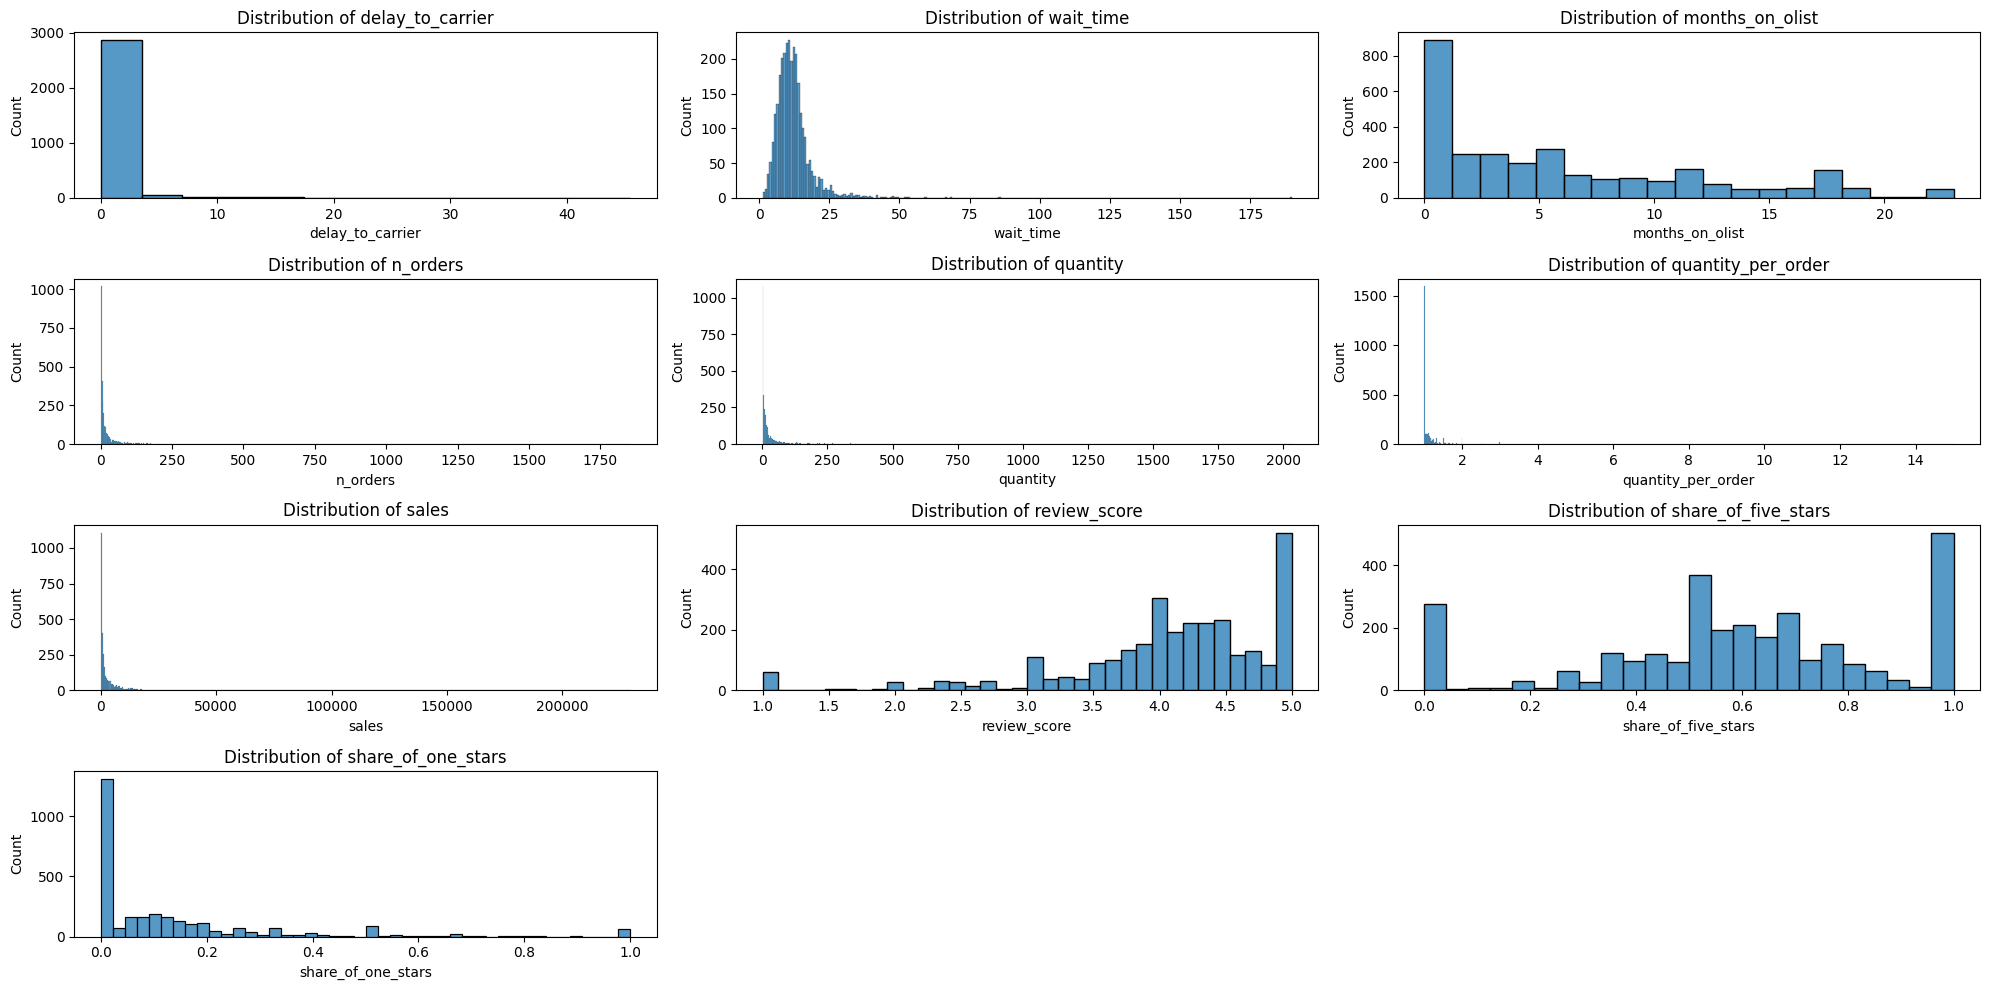

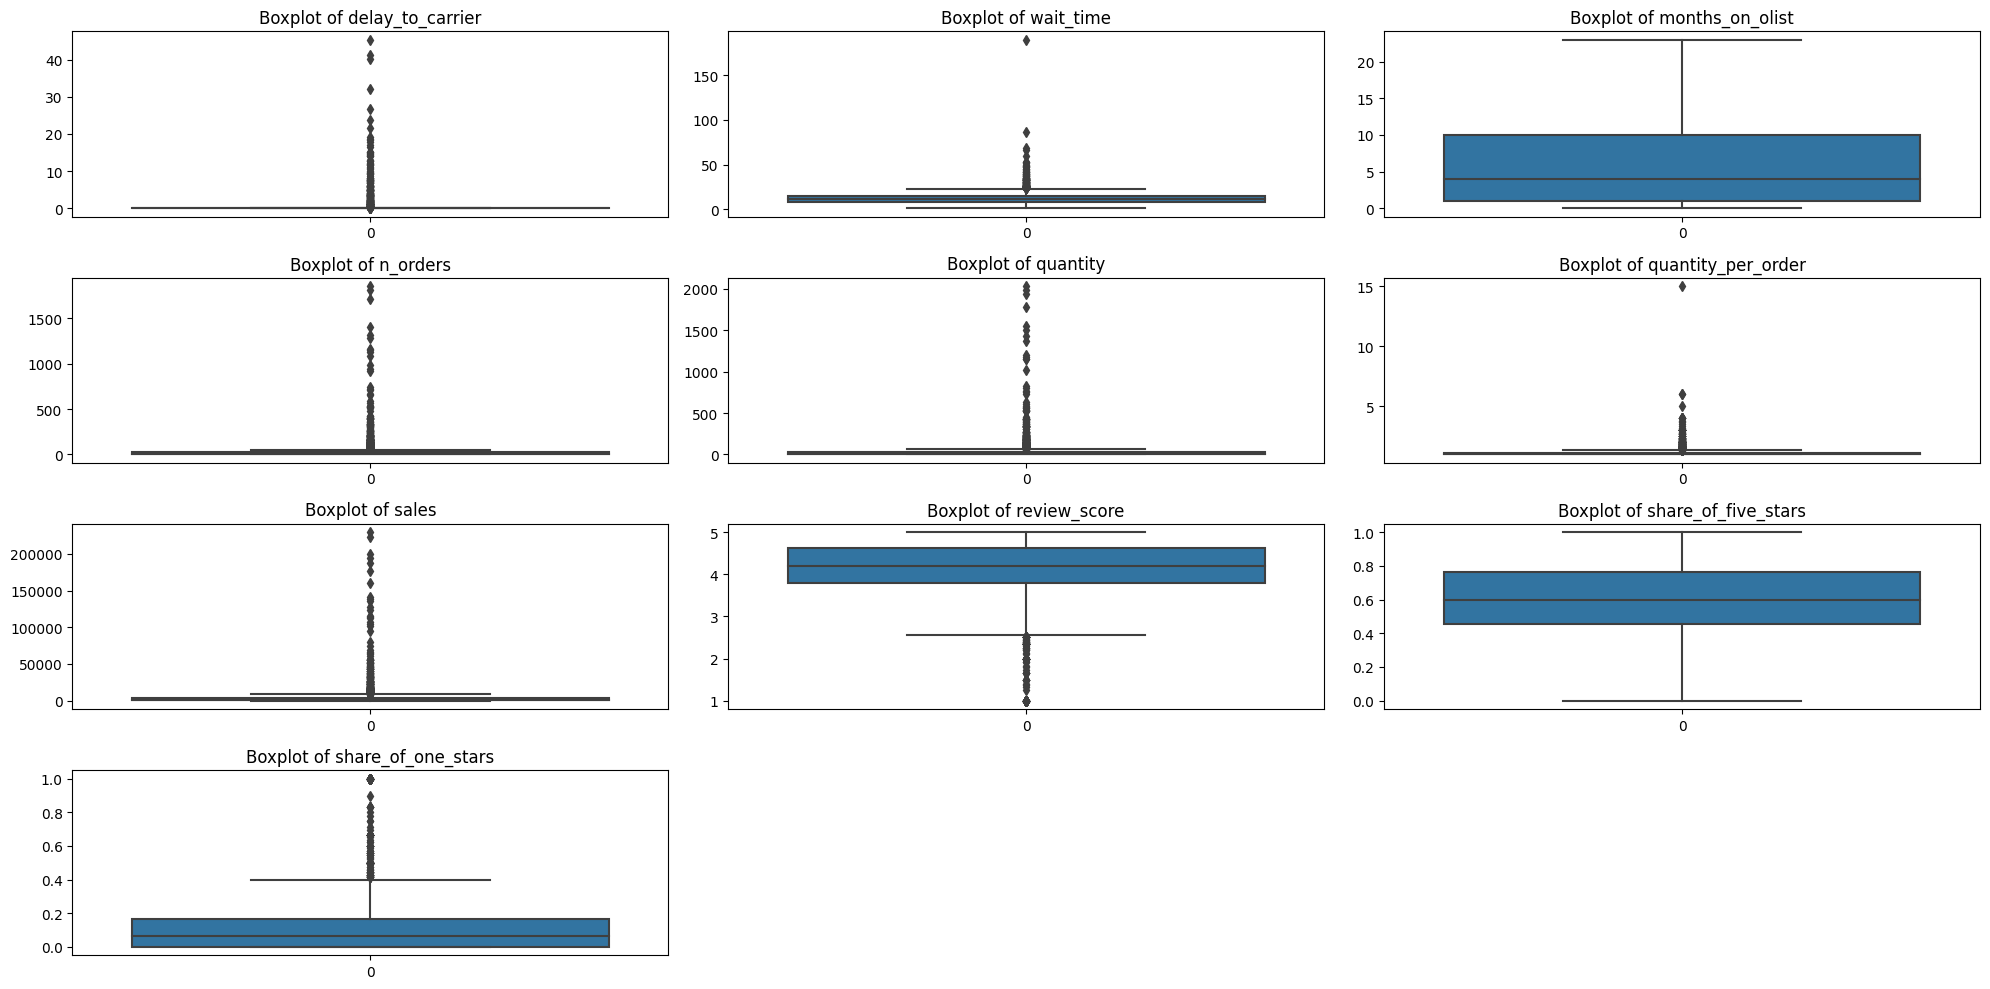

The median number of orders per seller is: 7.0


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


sellers = Seller().get_training_data()
plt.figure(figsize=(20, 10))
num_cols = sellers.select_dtypes(include='number').columns.tolist()
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3+1, 3, i+1)
    sns.histplot(sellers[col], kde=False)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3+1, 3, i+1)
    sns.boxplot(data=sellers[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

median_orders = sellers['n_orders'].median()
print(f"The median number of orders per seller is: {median_orders}")

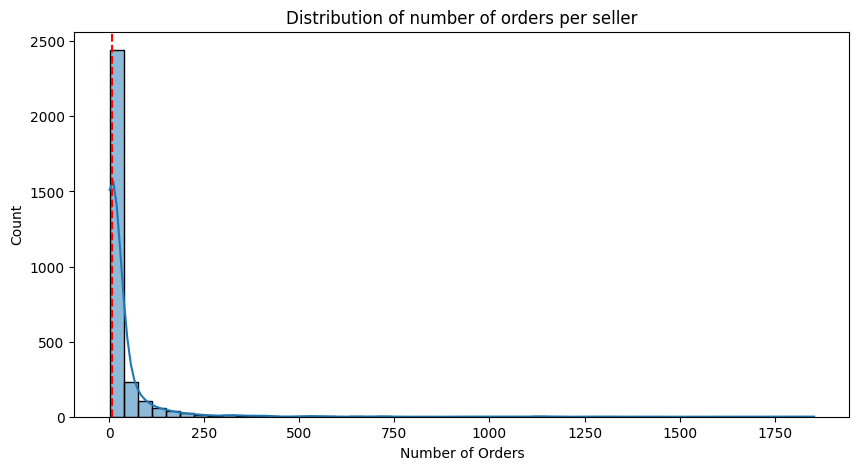

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(sellers['n_orders'], bins=50, kde=True)
plt.title('Distribution of number of orders per seller')
plt.xlabel('Number of Orders')
plt.ylabel('Count')
plt.axvline(median_orders, color='red', linestyle='--')
plt.show()

💡There seems to be a group of sellers which stands out for having very low review scores! 

📊 Let's investigate graphically it:
* Using `plotly`, create a `scatterplot` of `delay_to_carrier` against `wait_time`, varying bubble size by total `sales` for that seller, and coloring by `review_score`. 

In [28]:
import plotly.express as px


sellers = Seller().get_training_data()
fig = px.scatter(sellers,
                 x='wait_time',
                 y='delay_to_carrier',
                 size='sales',
                 color='review_score',
                 hover_name='seller_id',
                 size_max=80,
                 color_continuous_scale=px.colors.sequential.Viridis,
                 title='Scatterplot of Delay to Carrier vs. Wait Time')

fig.update_layout(xaxis_title='Wait Time',
                  yaxis_title='Delay to Carrier',
                  coloraxis_colorbar=dict(title='Review Score'))
fig.show()

Feel free to change values `x`, `y`, `color` and `size` to try identify who are the worst sellers

### (2.2) Model out `review_score` with OLS

⚠️ Scatter plots have their limits. 

💡 A more rigorous way to explain **`sellers' review_score`** is to **model the impact of various features on `review_score` with a `multivariate-OLS` in `statsmodels`**.

👉 Create an OLS with numerical features of your choice. 

❓ What are the most impactful ones? 

⚠️ Don't forget to standardize your features using the `standardize`function below to compare the regression coefficients together. 

In [30]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [31]:
import statsmodels.api as sm


features_to_standardize = ['delay_to_carrier', 'wait_time', 'sales', 'n_orders']
sellers_standardized = standardize(sellers, features_to_standardize)

X = sellers_standardized[features_to_standardize]
y = sellers_standardized['review_score']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     161.4
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          3.97e-125
Time:                        14:15:59   Log-Likelihood:                -3343.7
No. Observations:                2967   AIC:                             6697.
Df Residuals:                    2962   BIC:                             6727.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.0749      0.014  

📊 Draw a `bar_plot` with sorted coefficients.

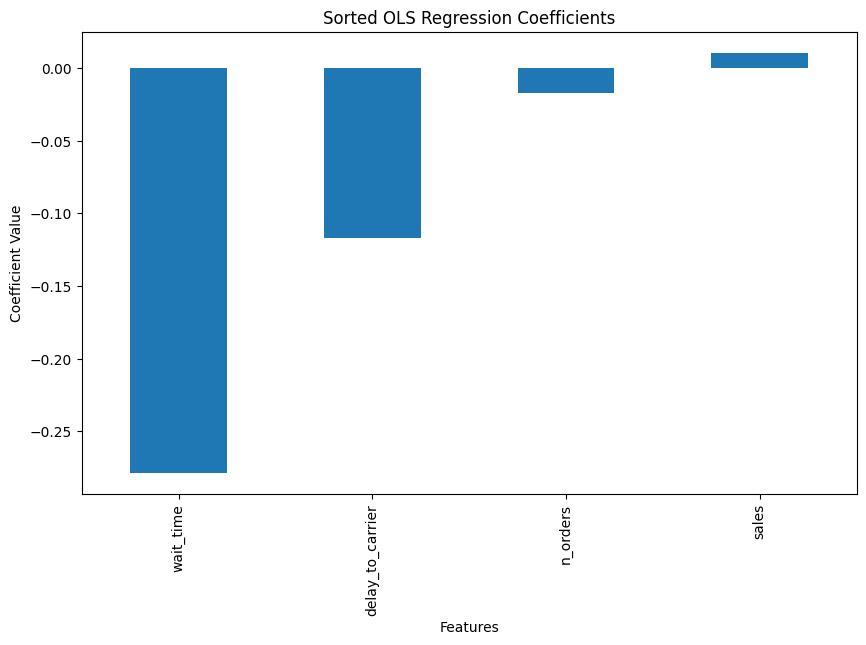

In [36]:
import matplotlib.pyplot as plt


coefficients = model.params[1:]
sorted_coefficients = coefficients.sort_values()
plt.figure(figsize=(10, 6))
sorted_coefficients.plot(kind='bar')
plt.title('Sorted OLS Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

👉 Finally, investigate your model's performance (`R-squared`) and `residuals`

R-squared value: 0.1790


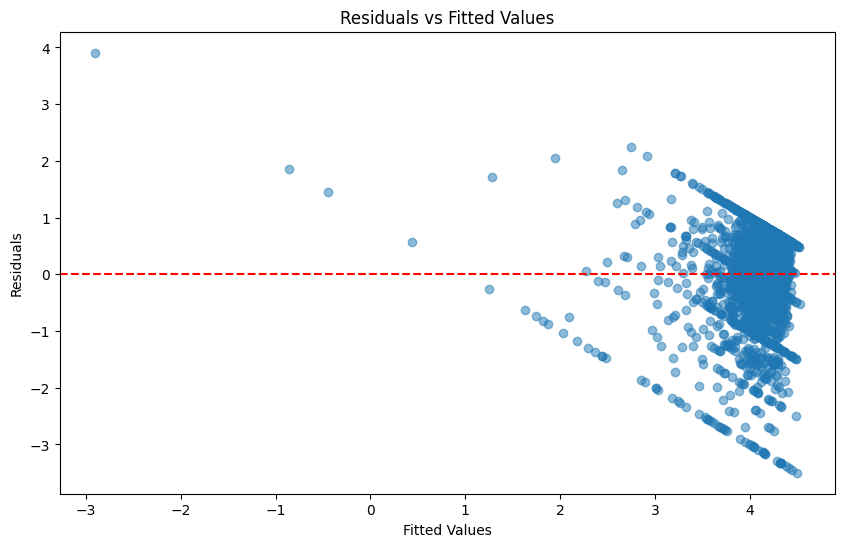

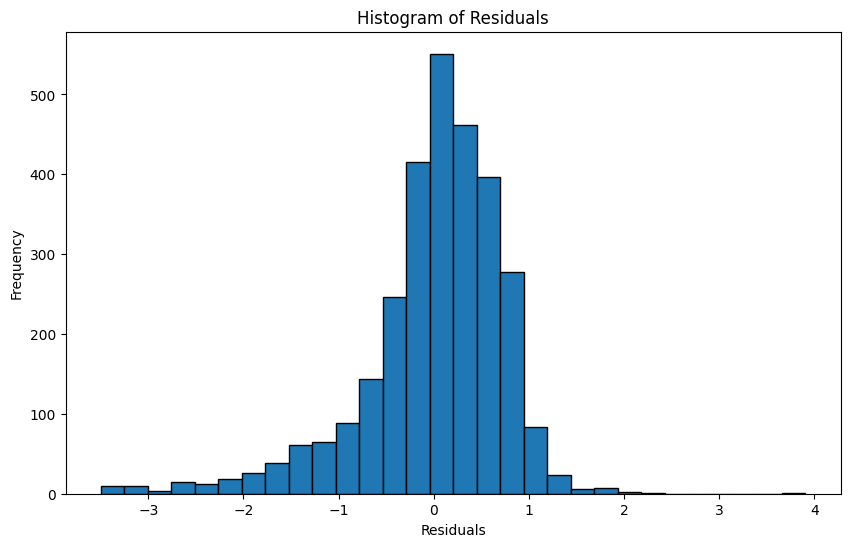

In [37]:
r_squared = model.rsquared
print(f'R-squared value: {r_squared:.4f}')


residuals = model.resid
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

👉 Compare the real review scores and the predicted scores by showing them on the same graph.

In [41]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


orders = your_dataframe
model = your_model

orders['predicted_review_score'] = model.predict(orders)

plt.figure(figsize=(12, 6))
plt.scatter(orders['review_score'], orders['predicted_review_score'], alpha=0.3)
plt.plot([orders['review_score'].min(), orders['review_score'].max()], [orders['review_score'].min(), orders['review_score'].max()], '--k')
plt.xlabel('Actual Review Score')
plt.ylabel('Predicted Review Score')
plt.title('Actual vs Predicted Review Scores')
plt.show()


residuals = orders['review_score'] - orders['predicted_review_score']
plt.figure(figsize=(12, 6))
plt.scatter(orders['predicted_review_score'], residuals, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Review Score')
plt.ylabel('Residuals')
plt.title('Residuals of Review Score Predictions')
plt.show()

NameError: name 'your_dataframe' is not defined

👉 Plot the residuals

NameError: name 'orders' is not defined

### (2.3) Add the `seller_state` to your analysis

❓ We haven't used information about `seller_state` yet.  
- Create a new OLS model regressing `review_score` on only on `seller_states` .
- Analyse your significant features using `return_significative_coef(model)` coded for you in `olist/utils.py`
- What are the best states in terms of `review_score`? 

<details>
    <summary>- Hints -</summary>
        
⚠️ Be careful, `seller_state` is a categorical feature. 
    
💡 Use `C(a_cat_feature)` in the formula to tell the linear regression model which variables are categorical variables. It will create one boolean variable `is_cat_feature_xx` **per unique category** 

</details>

In [ ]:
# YOUR CODE HERE

☝️ Some states indeed have _significantly_ better reviews than others on average. 

🤔 Is it due to some lower `quantity_per_order`, lower `wait_time`, or `delay_to_carrier`?  Or is it due to some other factors that we haven't collected data about?

❓ **Try to isolate the impact of the `seller_state` from the rest by adding other continuous features to your OLS until `seller_states` is no longer statistically siginificant!**

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

☝️ After adding `wait_time` to our analysis, none of the 22 dummy variables `is_seller_state_xx` are statistically signigicant:

Given our small dataset (most states have a very limited number of sellers):
- We _cannot conclude_ that "some states are inherently better than other for reasons that would be independent of the `wait_time`" 
- In other words, we _cannot reject the hypothesis_ that "seller_state has no impact on review_score, other than through `wait_time`"

🏁 Congratulations!

💾 Commit and push :
* your ` sellers.ipynb`notebook 
* as well as `seller.py`